# Importing Libraries

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import re 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords') 
from nltk.stem import WordNetLemmatizer
import numpy as np 
import pandas as pd
import datetime as dt

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Understanding

In [2]:
# loading the dataset
data = pd.read_csv("../input/covid19-sentiments/COVID-19_Sentiments.csv")

In [3]:
## viewing the dataset
data.head()

,Text_Id,Text,Date,Location,Sentiments
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,"Uttar Pradesh, India",0.000
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,Mumbai,0.000
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",Fri Mar 20 16:04:29 +0000 2020,"Jodhpur, India",0.350
3,1241032877099237379,RT @narendramodi: The young actors have someth...,Fri Mar 20 16:04:29 +0000 2020,"Gurugram, Bharat",0.125
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:28 +0000 2020,"New Delhi, India",0.000


In [4]:
# checking the bottom of the dataset
data.tail()

,Text_Id,Text,Date,Location,Sentiments
648953,1266955718772559873,"For the first time perhaps, someone to took ti...",Sun May 31 04:52:36 +0000 2020,India,0.446429
648954,1266955725936287746,RT @hvgoenka: 70 year Kamalamma offered an NGO...,Sun May 31 04:52:38 +0000 2020,"Nagpur, India",-0.250000
648955,1266955735537266688,Odisha reports 129 new #COVID19 positive cases...,Sun May 31 04:52:40 +0000 2020,"New Delhi, India",0.057576
648956,1266955733297397761,@nidhiindiatv Happy rainy day ..\n\nHope rain ...,Sun May 31 04:52:40 +0000 2020,"Muzaffarnagar, India",0.200000
648957,1266955733255536640,RT @nsui: Kerala Student Union activists did S...,Sun May 31 04:52:40 +0000 2020,"New Delhi, India",0.000000


In [5]:
### the shape of the data
data.shape

(648958, 5)

In [6]:
## data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648958 entries, 0 to 648957
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Text_Id     648958 non-null  int64  
 1   Text        648958 non-null  object 
 2   Date        648958 non-null  object 
 3   Location    648958 non-null  object 
 4   Sentiments  637978 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 24.8+ MB


# Data Cleaning and Manipulation

**Duplicated entries**

In [7]:
# check for duplicates
if data.duplicated().any():
    print('Duplicates Found')
else:    
    print('No Duplicates Found')

Duplicates Found


In [8]:
# removing Dupicates
data = data.drop_duplicates().reset_index(drop=True)

In [9]:
data.shape

(324960, 5)

**Missing values**

In [10]:
### missing values
data.isnull().sum()

Text_Id          0
Text             0
Date             0
Location         0
Sentiments    5072
dtype: int64

**More data cleaning procedures**

In [11]:
#imputing the missing sentiments
data['Sentiments'].fillna(data['Sentiments'].mean(),inplace=True)

In [12]:
#changing the date to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create features for year, month, day
data['year'] = data['Date'].dt.year 
data['month'] = data['Date'].dt.month 
data['day'] = data['Date'].dt.day 

In [13]:
data.head()

,Text_Id,Text,Date,Location,Sentiments,year,month,day
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,2020-03-20 16:04:27+00:00,"Uttar Pradesh, India",0.000,2020,3,20
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,2020-03-20 16:04:27+00:00,Mumbai,0.000,2020,3,20
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",2020-03-20 16:04:29+00:00,"Jodhpur, India",0.350,2020,3,20
3,1241032877099237379,RT @narendramodi: The young actors have someth...,2020-03-20 16:04:29+00:00,"Gurugram, Bharat",0.125,2020,3,20
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,2020-03-20 16:04:28+00:00,"New Delhi, India",0.000,2020,3,20


In [14]:
#dropping columns that we do not need
data = data.drop(["Date", "year"], 1) #the year column has same value(2020)

print(data.columns)

Index(['Text_Id', 'Text', 'Location', 'Sentiments', 'month', 'day'], dtype='object')


**Reducing the sentiments to only 3 values**

In [15]:
# function to make the changes on the sentiment column
def classes_def(x):
    if x < 0:
        return "Negative"
    elif x > 0:
        return "Positive"
    else:
        return "Neutral"
    
data['Sentiments']=data['Sentiments'].apply(lambda x:classes_def(x))

target=data['Sentiments']

In [16]:
# checking the distribution of the sentiment column
data['Sentiments'].value_counts()

Positive    134413
Neutral     129729
Negative     60818
Name: Sentiments, dtype: int64

>There is not a huge imbalance between the different classes. 

# Exploratory EDA

## **Count Plot of the sentiment classes**

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

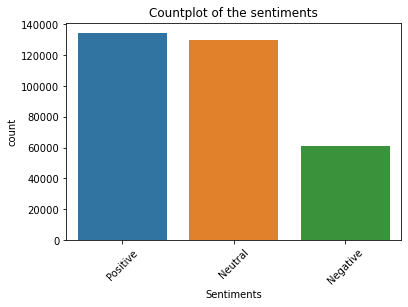

In [17]:
# Count plot of sentiments
sns.countplot(data['Sentiments'], order = data['Sentiments'].value_counts().index)
plt.title("Countplot of the sentiments")
plt.xticks(rotation=45)

In [18]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
     "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited","ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [19]:
# We will copy the text in another column so that the original text is also there for comparison

data['ctext'] = data.Text.astype(str)
def text_cleaner(text):
    temp = text.lower()
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    temp = url_pattern.sub(r'', temp)
    html=re.compile(r'<[^>]+>')
    temp = html.sub(r'',temp)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    temp = emoji_pattern.sub(r'', temp)
    
    table=str.maketrans('','',string.punctuation)
    temp = temp.translate(table)
    
    tem=[]
    for word in temp.split():
        if word in abbreviations.keys():
            tem.append(abbreviations[word])
        else:
            tem.append(word)
    temp=tem
    return (" ".join(temp)).strip()
data['ctext'] = data['ctext'].apply(lambda text: text_cleaner(text))    
data.head()

,Text_Id,Text,Location,Sentiments,month,day,ctext
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,"Uttar Pradesh, India",Neutral,3,20,retweet theskindoctor13 shaheen bagh is still ...
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,Mumbai,Neutral,3,20,retweet theskindoctor13 shaheen bagh is still ...
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...","Jodhpur, India",Positive,3,20,retweet smokingskills daughter of an ias son o...
3,1241032877099237379,RT @narendramodi: The young actors have someth...,"Gurugram, Bharat",Positive,3,20,retweet narendramodi the young actors have som...
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,"New Delhi, India",Neutral,3,20,retweet theskindoctor13 shaheen bagh is still ...


## **Number of characters in a tweet per sentiment**

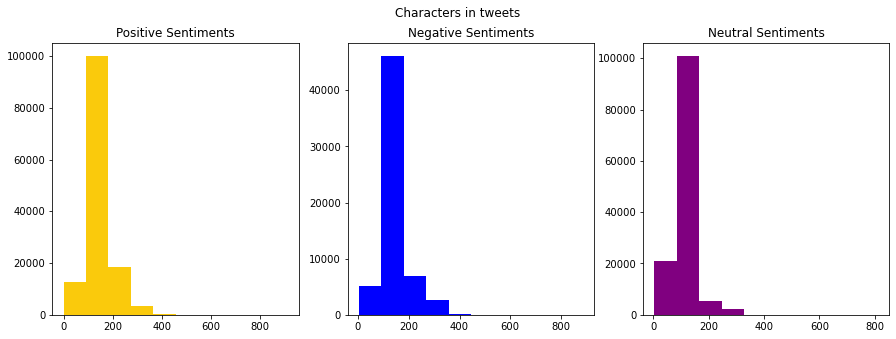

In [20]:
# defining the number of plots to make and figure size
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

# number of characters in the positive sentiments
tweet_len_positive=data[data['Sentiments']=="Positive"]['ctext'].str.len()
ax1.hist(tweet_len_positive,color='#FACA0C')
ax1.set_title('Positive Sentiments')

# number of characters in the negative sentiments
tweet_len_negative=data[data['Sentiments']=="Negative"]['ctext'].str.len()
ax2.hist(tweet_len_negative,color='blue')
ax2.set_title('Negative Sentiments')

# number of characters in the neutral sentiments
tweet_len_neutral=data[data['Sentiments']=="Neutral"]['ctext'].str.len()
ax3.hist(tweet_len_neutral,color='purple')
ax3.set_title('Neutral Sentiments')



fig.suptitle('Characters in tweets')
plt.show()

## **Number of words per tweets**

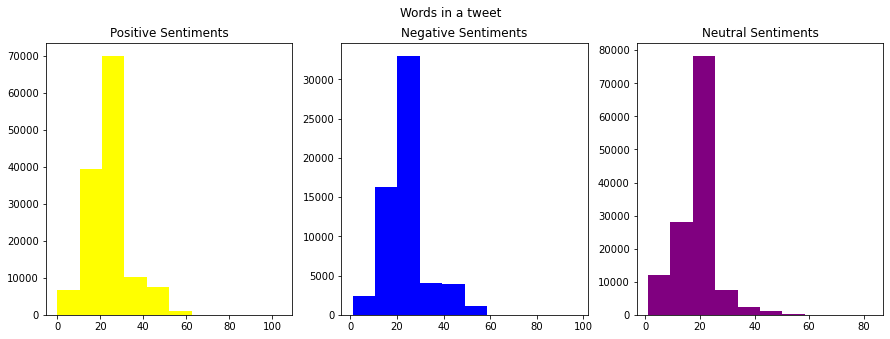

In [21]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len_positive=data[data['Sentiments']=="Positive"]['ctext'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len_positive,color='yellow')
ax1.set_title('Positive Sentiments')

tweet_len_negative=data[data['Sentiments']=="Negative"]['ctext'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len_negative,color='blue')
ax2.set_title('Negative Sentiments')

tweet_len_neutral=data[data['Sentiments']=="Neutral"]['ctext'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len_neutral,color='purple')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

## **Stop words**

In [22]:
# function to check for stop words in each sentiment group
def create_corpus(target):
  corpus=[]
  
  for x in data[data['Sentiments']==target ]['ctext'].str.split():
    for i in x:
      corpus.append(i)
  
  return corpus

In [23]:
# initialize a variable to contain stopwords in English
stop_words = set(stopwords.words('english')) 

# tokens of words 
word_tokens = data['ctext'].apply(nltk.word_tokenize) 
# word_tokens = word_tokenize(data['text']) 
    
stop = [] 
  
for w in word_tokens: 
  for w in stop_words: 
    stop.append(w) 

## **Common words**

<font color='blue'>Positive sentiments

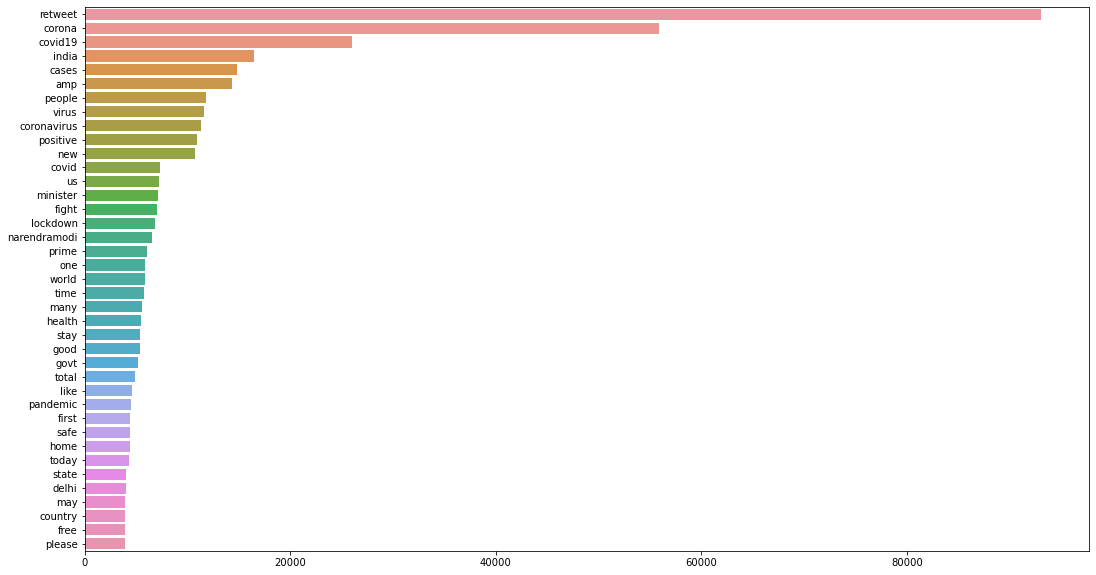

In [24]:
from collections import defaultdict, Counter

# checking for common words in the class "Positive"
corpus=create_corpus("Positive")
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
# for loop to append the word and count for most common words to empty lists
for word,count in most[:100]:
  # do not include stop words
  if (word not in stop) :
    x.append(word)
    y.append(count)

# plotting
plt.figure(figsize=(18,10))
sns.barplot(x=y,y=x)

<font color='blue'>Negative sentiments

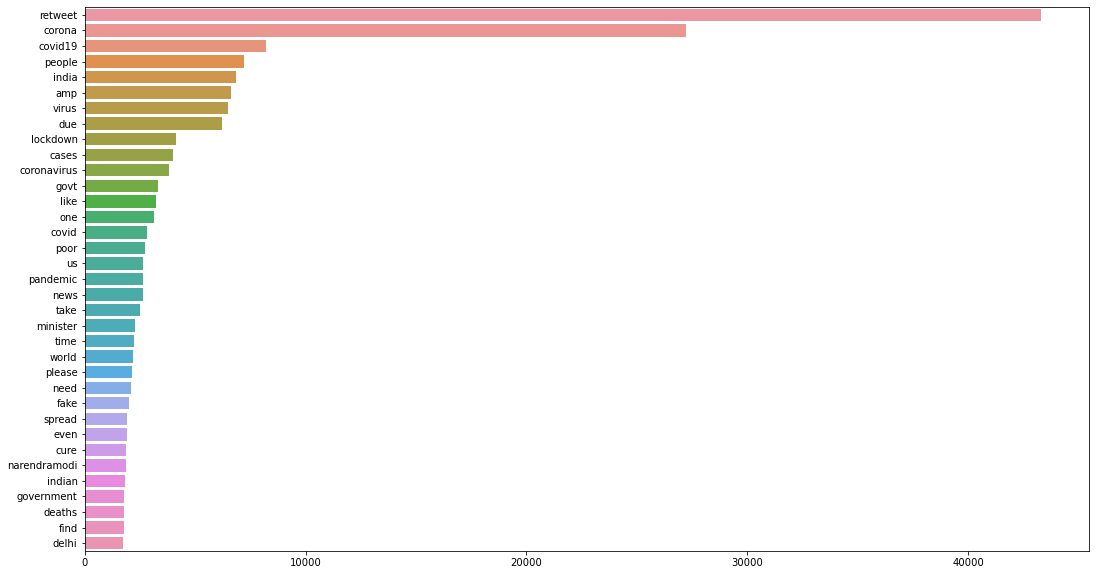

In [25]:
# checking for common words in the class "Negative"
corpus=create_corpus("Negative")
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
# for loop to append the word and count for most common words to empty lists
for word,count in most[:100]:
  # do not include stop words
  if (word not in stop) :
    x.append(word)
    y.append(count)

# plotting
plt.figure(figsize=(18,10))
sns.barplot(x=y,y=x)

<font color='blue'>Neutral sentiments

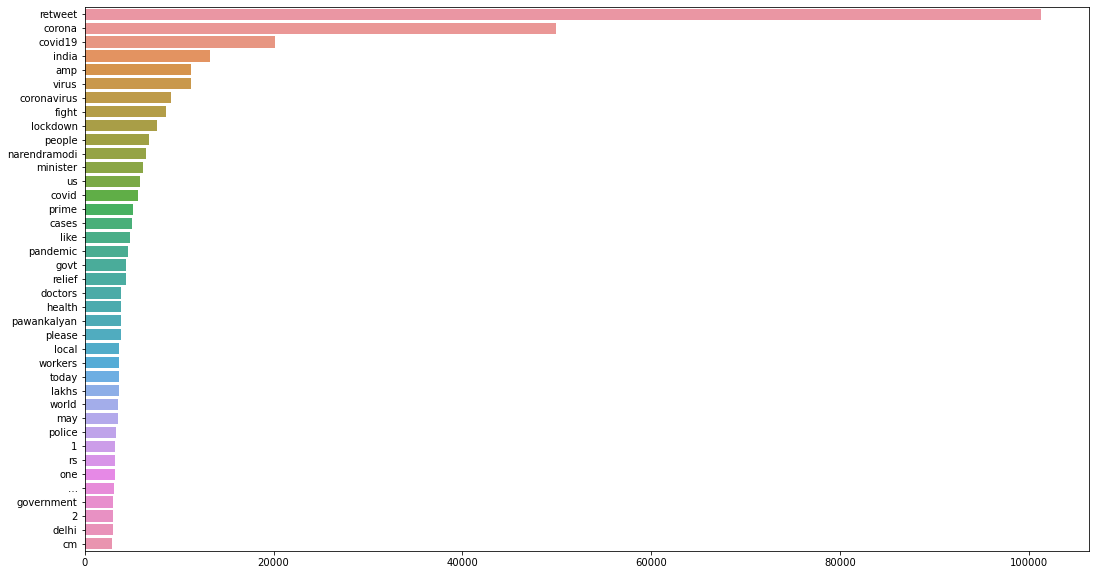

In [26]:
# checking for common words in the class "Neutral"
corpus=create_corpus("Neutral")
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
# for loop to append the word and count for most common words to empty lists
for word,count in most[:100]:
  # do not include stop words
  if (word not in stop) :
    x.append(word)
    y.append(count)

# plotting
plt.figure(figsize=(18,10))
sns.barplot(x=y,y=x)

## **Most polular Hashtags for the period**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text major ticklabel objects>)

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0, flags=flags)


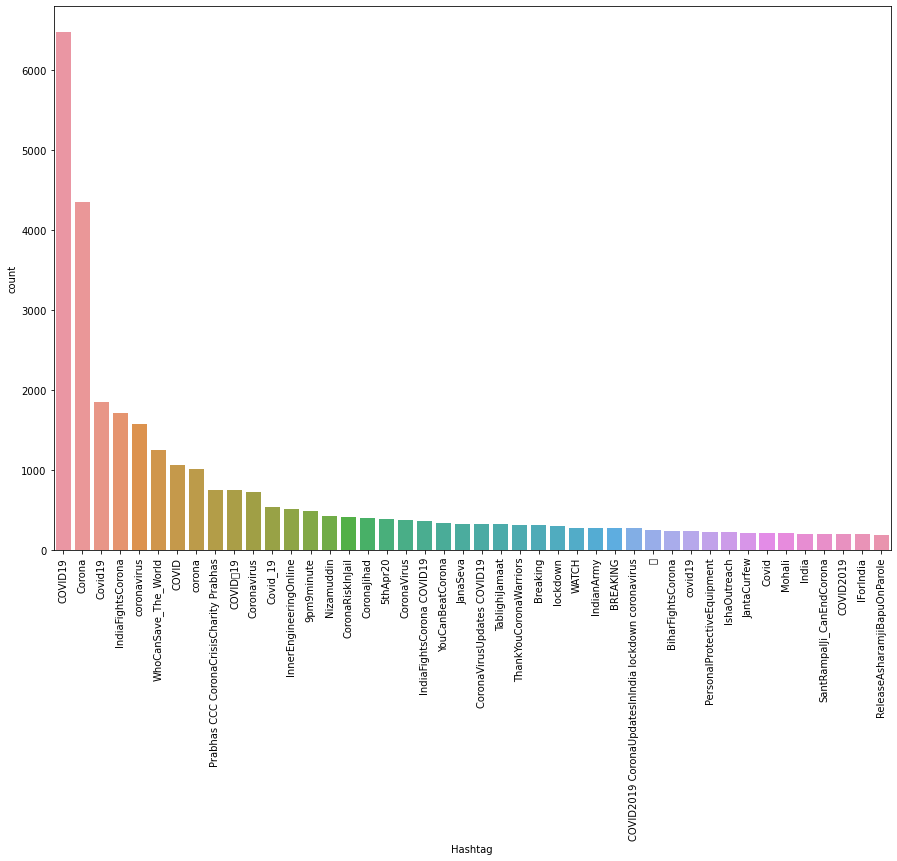

In [33]:
# function to find hashtags in the text
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)

# apply the function to the text
data['hash']=data['Text'].apply(lambda x:find_hash(x))

# create a temporary dataframe that contains the value counts for the top 45 most popular hashtags
temp1=data['hash'].value_counts()[:][1:45]
temp1= temp1.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})

# make a plot of the popular hashtags
plt.figure(figsize=(15,10))
sns.barplot(x="Hashtag",y="count", data = temp1)
plt.xticks(rotation=90)

## **Most popular mentions**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68]),
 <a list of 69 Text major ticklabel objects>)

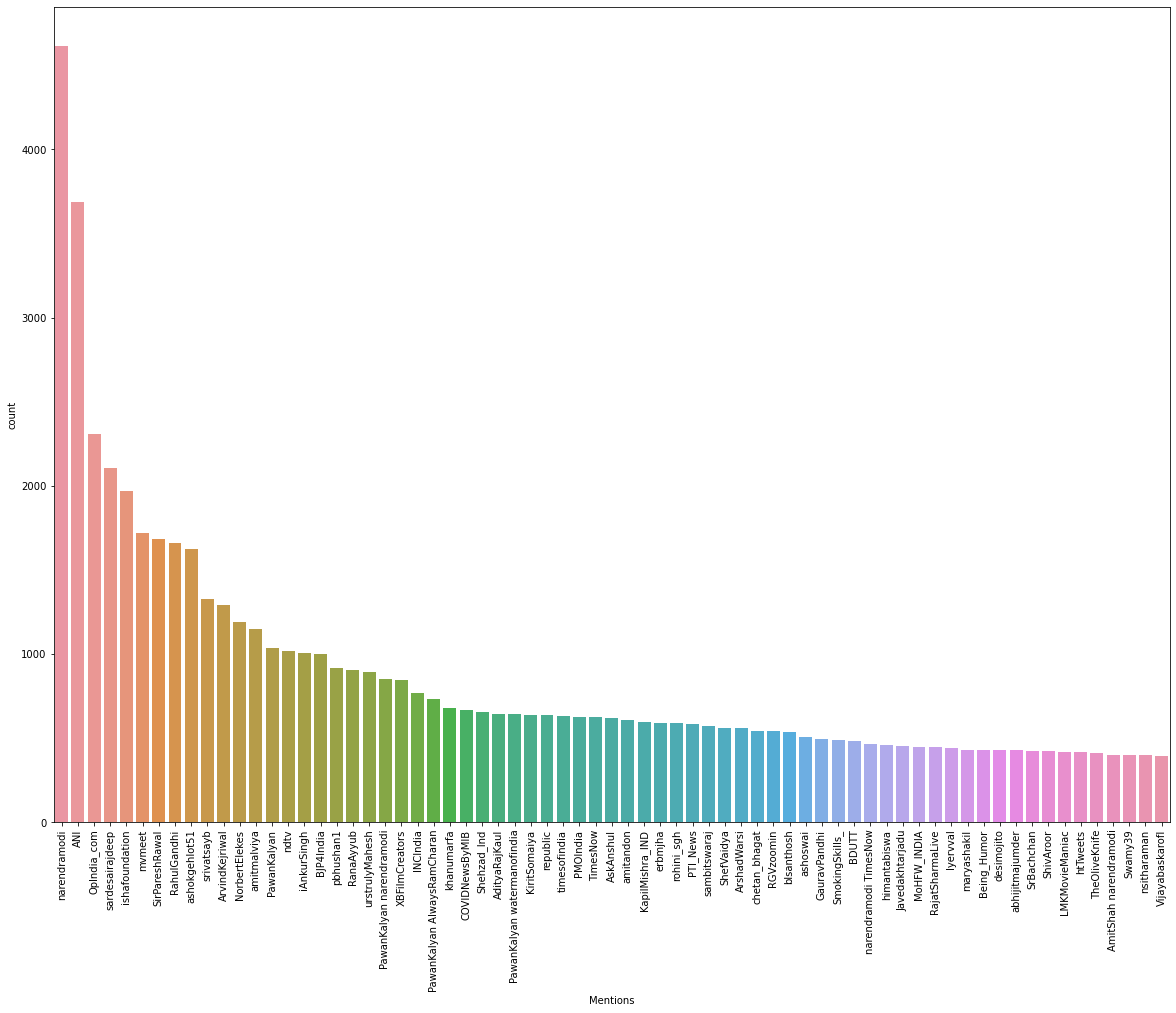

In [34]:
# function to find mentions(@) in the text
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)

 # apply the function to the text   
data['mentions']=data['Text'].apply(lambda x:mentions(x))

# create a temporary dataframe that contains the value counts for the top 70 most popular mentions
temp2=data['mentions'].value_counts()[:][1:70]
temp2 =temp2.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

# make a plot of the popular hashtags
plt.figure(figsize=(20,15))
sns.barplot(x="Mentions",y="count", data = temp2)
plt.xticks(rotation=90)


In [35]:
# create a temporary dataframe that contains the hashtags 
temp_hash=data['hash'].value_counts()
temp_hash= temp_hash.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count', 'location':'location'})

# create a temporary dataframe that contains the mentions 
temp_men=data['mentions'].value_counts()
temp_men=temp_men.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count', 'location':'location'})

# # export the dataframes as csv files for use to plot on tableau
# hashtags = temp_hash.to_csv("h#shtags.csv")
# mentions = temp_men.to_csv("m@ntions.csv")



## **Word Clouds for each Sentiment**

<font color='blue'>Positive sentiments

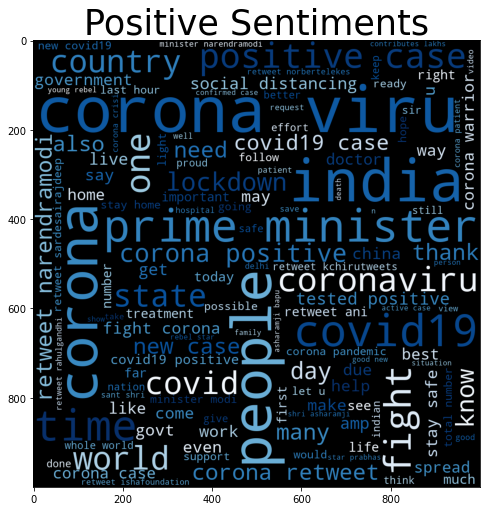

In [36]:
from wordcloud import WordCloud 
data_pos = data[data["Sentiments"]=="Positive"]
data_neg = data[data["Sentiments"]=="Negative"]
data_neu = data[data["Sentiments"]=="Neutral"]

comment_words = '' 
stopwords = set(stop_words) 

for val in data_pos.ctext: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud1 = WordCloud(width = 1000, height = 1000, 
                background_color ='black',
                colormap="Blues",
                stopwords = stopwords, 
                min_font_size = 15).generate(comment_words) 
plt.figure(figsize=(8,10))
ax1 = plt.imshow(wordcloud1)
# ax1.axis('off')
plt.title('Positive Sentiments',fontsize=35);

<font color='blue'>Negative sentiments

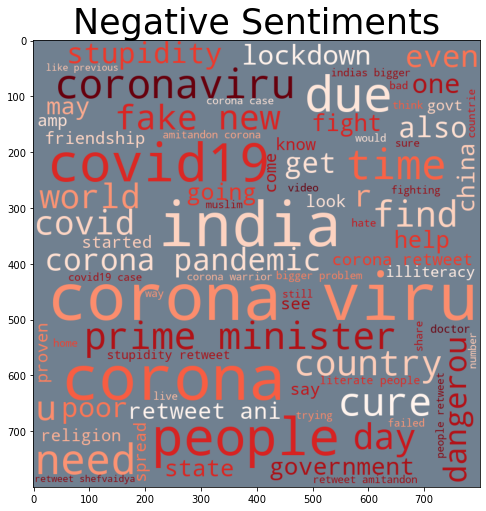

In [37]:
comment_words = ''

for val in data_neg.ctext: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='slategrey',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 15).generate(comment_words)  
plt.figure(figsize=(8,10))
ax2=plt.imshow(wordcloud2)
# ax2.axis('off')
plt.title('Negative Sentiments',fontsize=35);


<font color='blue'>Neutral sentiments

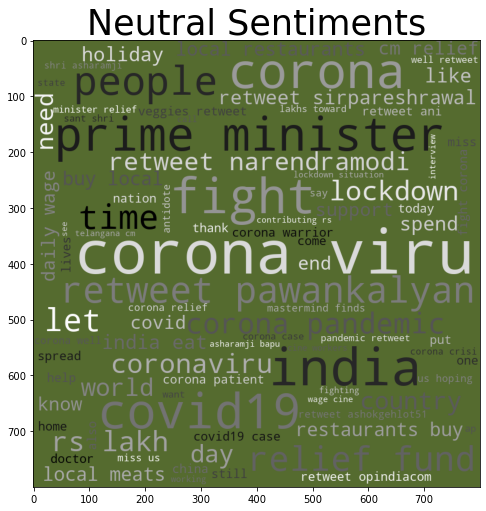

In [38]:
comment_words = ''
for val in data_neu.ctext: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='darkolivegreen',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 15).generate(comment_words) 
plt.figure(figsize=(8,10))
ax3 = plt.imshow(wordcloud3)
# ax3.axis('off')
plt.title('Neutral Sentiments',fontsize=35);

# **Pre-processing**

In [39]:
import re
import nltk
import nltk
nltk.download('wordnet')
lemma = WordNetLemmatizer()


def cleaner(orig_tweet):
    # remove urls/links
    orig_tweet = re.sub(r'http\S+', ' ', orig_tweet)
    
    # remove html tags
    orig_tweet = re.sub(r'<.*?>',' ', orig_tweet)
    
    # remove digits
    orig_tweet = re.sub(r'\d+',' ', orig_tweet)

    # remove hashtags
    orig_tweet = re.sub(r'#\w+',' ', orig_tweet)
    
    # remove mentions
    orig_tweet = re.sub(r'@\w+',' ', orig_tweet)

    # Removing any punctuation
    orig_tweet = re.sub(r'[^\w\s]', '', orig_tweet)

     # converting all characters to lowercase
    orig_tweet = str(orig_tweet).lower()

    # tokenization
    orig_tweet = word_tokenize(orig_tweet)
    
    #removing stop words
    orig_tweet = [word for word in orig_tweet if word not in stop_words]
    
    # lemmatization
    orig_tweet = [lemma.lemmatize(word=w, pos='v') for w in orig_tweet]

    # remove words with length <=2
    orig_tweet = [i for i in orig_tweet if len(i) > 2]

    return orig_tweet


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
# apply the function to the text column for easy comparison with the original tweet
data['ctext'] = data['ctext'].apply(cleaner)

In [41]:
# check the dataframe to see changes made
data.sample(10)

,Text_Id,Text,Location,Sentiments,month,day,ctext,hash,mentions
117937,1247451079970705409,"RT @ANI: Visakhapatnam: Dr Sudhakar Rao, an an...",India,Negative,4,7,"[retweet, ani, visakhapatnam, sudhakar, rao, a...",,ANI
204666,1253193169287516160,RT @AmitShah: Truth is self evident!\n\nEntire...,"Guwahati, Assam,India",Positive,4,23,"[retweet, amitshah, truth, self, evident, enti...",,AmitShah narendramodi
18056,1242330905496023040,RT @sanghaviharsh: #Corona Update 23 March 11....,"Lunawada,Gujarat, India",Positive,3,24,"[retweet, sanghaviharsh, corona, update, march...",Corona,sanghaviharsh
210874,1253556367345868801,RT @timesofindia: 18 new positive cases of Cov...,"Jharkhand, India",Positive,4,24,"[retweet, timesofindia, new, positive, case, c...",,timesofindia
153364,1249583395727794177,"RT @BDUTT: ""They called me China Ka Maal &amp;...","Dhenkanal, India",Negative,4,13,"[retweet, bdutt, call, china, maal, amp, halfc...",,BDUTT GuttaJwala
176779,1250664899178459137,@Sachchi_Soch9 @CMOGuj @vnehra @AMC_Feedback @...,"Ahmadabad City, India",Positive,4,16,"[sachchisoch, cmoguj, vnehra, amcfeedback, dym...",,Sachchi_Soch9 CMOGuj vnehra AMC_Feedback DyMC_CZ
280526,1262242258188812289,RT @coolfunnytshirt: Covid 19 pandemic is forc...,"Indore, India",Neutral,5,18,"[retweet, coolfunnytshirt, covid, pandemic, fo...",,coolfunnytshirt
105929,1247046235640352773,RT @Lala_The_Don: Sagarika-Corona 2020 is the ...,"Delhi, India",Positive,4,6,"[retweet, lalathedon, sagarikacorona, year, cm...",,Lala_The_Don
116634,1247444488445820928,Our corona special Bollywood awareness series ...,"Rajasthan, India",Positive,4,7,"[corona, special, bollywood, awareness, series]",,
174034,1250648333468594177,@yehlog @MumbaiPolice @OfficeofUT @CyberDost @...,india,Negative,4,16,"[yehlog, mumbaipolice, officeofut, cyberdost, ...",,yehlog MumbaiPolice OfficeofUT CyberDost Twitt...


In [42]:
# Finally, we will transform the data into occurrences, 
# 
from sklearn.feature_extraction.text import CountVectorizer

# This converts the list of words into space-separated strings
data['ctext'] = data['ctext'].apply(lambda x: ' '.join(x))

count_vect = CountVectorizer()
counts = count_vect.fit_transform(data['ctext'])

In [43]:
# We could leave it as the simple word-count per message, but it is better to use Term Frequency Inverse Document Frequency, more known as tf-idf
# 
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts)

counts = transformer.transform(counts)

# **Modelling**

## Naive Bayes Model

In [44]:
from sklearn.model_selection import train_test_split

# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(counts, data['Sentiments'], test_size=0.2, random_state=69)

from sklearn.naive_bayes import MultinomialNB

# modelling using the Multinomial Naive Bayes model
model = MultinomialNB().fit(X_train, y_train)

# predicting using test set
predicted = model.predict(X_test)
print(np.mean(predicted == y_test)) #getting accuracy of the model

0.7883277941900542


## Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
random=RandomForestClassifier(n_estimators=5,  random_state=82)
random.fit(X_train, y_train)  

RandomForestClassifier(n_estimators=5, random_state=82)

In [46]:
# Prediction 
y_pred = random.predict(X_test)

# Evaluation of the model
print(np.mean(y_pred == y_test))

0.9030496061053668


## Bernolli NB

In [49]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(binarize = 0.1)

model = clf.fit(X_train, y_train)

In [48]:
# Prediction 
y_pred = model.predict(X_test)

# Evaluation of the model
print(np.mean(y_pred == y_test))

0.8359644263909404


SVM

In [ ]:
# Building the model 
from sklearn.svm import SVC
rbf = SVC(kernel='rbf', gamma=4, C=10)
# Training the model using the training set
rbf.fit(X_train, y_train)

In [ ]:
# Prediction 
y_pred = rbf.predict(X_test)

# Evaluation of the model
print(np.mean(y_pred == y_test))

## Neural Networks

TensorFlow

The best model for predicting sentiments according to their accuracy is Bernoulli with an accuracy of 
81.9% 

In [52]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def text_cleaner(text):
    temp = text.lower()
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    temp = url_pattern.sub(r'', temp)
    html=re.compile(r'<[^>]+>')
    temp = html.sub(r'',temp)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    temp = emoji_pattern.sub(r'', temp)
    
    table=str.maketrans('','',string.punctuation)
    temp = temp.translate(table)
    
    tem=[]
    for word in temp.split():
        if word in abbreviations.keys():
            tem.append(abbreviations[word])
        else:
            tem.append(word)
    temp=tem
    
    stop_words = set(stopwords.words('english'))
    le=WordNetLemmatizer()
    tokens = [le.lemmatize(word) for word in temp if not word in stop_words]
    
    long_words=[]
    for i in tokens:
        if len(i)>1:                                            
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [53]:
X_features = data['Text'].copy()
X_cleaned=X_features.apply(text_cleaner)
tk = Tokenizer()
tk.fit_on_texts(X_cleaned)
X = tk.texts_to_sequences(X_cleaned)
X = pad_sequences(X, padding="post")

In [63]:
dic = {'Positive':1,'Neutral':0,'Negative':2}
Y = data['Sentiments'].apply(lambda x : dic[x]) 

In [69]:
vocab_size = len(tk.word_index)+1
tf.keras.backend.clear_session()
# hyper parameters
EPOCHS = 2
BATCH_SIZE = 1024
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(3,activation = 'softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 82, 16)            2902352   
_________________________________________________________________
bidirectional (Bidirectional (None, 82, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 3,462,995
Trainable params: 3,462,995
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(X,Y,verbose=1,batch_size = 2048,validation_split=0.2,epochs = 5)
model.save('LSTM.h5')

Epoch 1/5
127/127 [==============================] - 877s 7s/step - loss: 0.1462 - accuracy: 0.9553 - val_loss: 0.1762 - val_accuracy: 0.9454
Epoch 2/5
127/127 [==============================] - 876s 7s/step - loss: 0.0922 - accuracy: 0.9730 - val_loss: 0.1922 - val_accuracy: 0.9414
Epoch 3/5
127/127 [==============================] - 886s 7s/step - loss: 0.0638 - accuracy: 0.9817 - val_loss: 0.2296 - val_accuracy: 0.9319
Epoch 4/5
127/127 [==============================] - 873s 7s/step - loss: 0.0474 - accuracy: 0.9871 - val_loss: 0.2419 - val_accuracy: 0.9297
Epoch 5/5
127/127 [==============================] - 883s 7s/step - loss: 0.0378 - accuracy: 0.9898 - val_loss: 0.2895 - val_accuracy: 0.9230
